In [1]:
from environment import Environment
from models.baseline import BaselineModel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data/train_preprocessed.csv')
test_data = pd.read_csv('data/validate_preprocessed.csv')

In [82]:
def print_func(battery, prices, actions, rewards):
    '''for i in range(100):
        print('t=%d, battery=%.2f, price=%.2f, action=%d, rewards=%.2f'%(i, battery[i], prices[i], actions[i], rewards[i]))
    '''
    
    print('total reward = ', sum(rewards))
    
    '''for i in range(len(battery)):
        if actions[i] != 25:
            hour = i%24
            print('t=%d, hour=%d battery=%.2f, price=%.2f, action=%d, rewards=%.2f'%(i, hour, battery[i], prices[i], actions[i], rewards[i]))
    '''
    
    return

def plot_func(battery, prices, actions, rewards):
    x = range(len(battery))
    
    charging = np.insert(np.diff(battery), 0, 0)
    cum_rewards = np.cumsum(np.array(rewards))
    
    fig, axis = plt.subplots(2,3, figsize=(12,8))
    for ax, val, name in zip(axis.flat, 
                             [battery, charging, prices, actions, rewards, cum_rewards],
                               ['Battery', 'Charging', 'Prices', 'Actions', 'Rewards', 'Cumulative rewards']):
        ax.scatter(x, val, s=1)
        ax.set_title(name)
    plt.show()
    
    
    cmap = plt.get_cmap('RdBu')
    plt.plot(x, prices)
    plt.scatter(x, prices, c=charging, cmap=cmap, edgecolors='grey')
    plt.xlabel('Time')
    plt.ylabel('Prices')
    plt.show()

    return


In [83]:
def learn(env, model, t_max):
    rewards, battery, revenues, actions, prices = [], [], [], [], []
    i=0
    obs, reward = env.reset()
    
    while i<t_max:
        action = model.predict(obs)
        battery.append(obs['battery'])
        prices.append(obs['price'])
        
        obs, reward, finished = env.step(action)
        
        actions.append(action)
        rewards.append(reward)
        i+=1
    
    return battery, prices, actions, rewards

total reward =  5760.721798106037


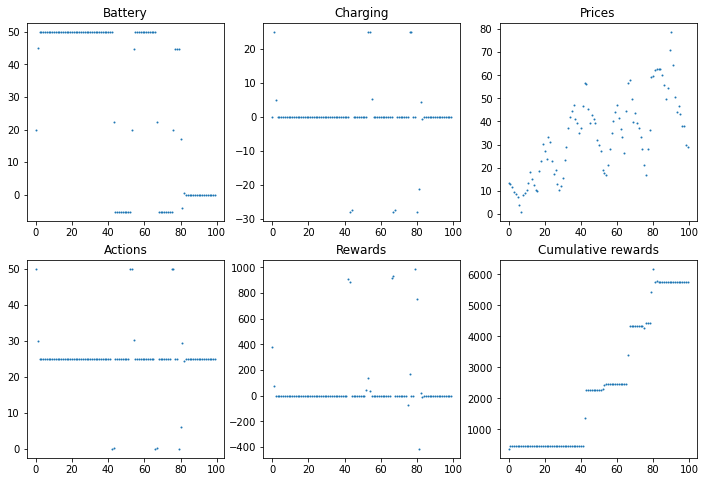

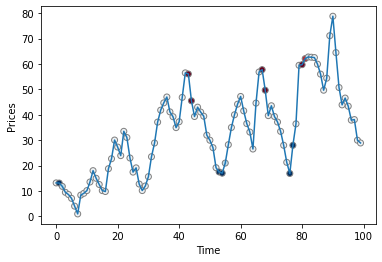

377.7777777777778


In [84]:
min_thres = [0.15]#[0.05, 0.10, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
max_thres = [0.6]#[0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


Rewards = []
for Min in min_thres:
    for Max in max_thres:
            env = Environment(test_data)
            model = BaselineModel(data, Min, Max)
            t_max = 100
            battery, prices, actions, rewards = learn(env, model, t_max)
            Rewards.append([sum(rewards), Min, Max])
            

            print_func(battery, prices, actions, rewards)
            plot_func(battery, prices, actions, rewards)
            
    max_idx = np.argmax(np.array(Rewards)[:,0])
    print(rewards[max_idx])